In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [12]:
def load_and_prepare_data(file_path, lookback=60):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    data = df[['Close']].values

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i - lookback:i, 0])
        y.append(scaled_data[i, 0])

    X = np.array(X)
    y = np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler, df

In [13]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
def train_and_evaluate(file_path, stock_name):
    print(f"\nTraining model for {stock_name}")
    lookback = 60
    X, y, scaler, df = load_and_prepare_data(file_path, lookback)
    
    split = int(0.8 * len(X))
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    model = build_lstm_model((lookback, 1))
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    # Plot evaluation metrics as a table
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.axis('tight')
    ax.axis('off')

    metrics = [
        ["Metric", "Value"],
        ["Mean Squared Error (MSE)", f"{mse:.4f}"],
        ["Root Mean Squared Error (RMSE)", f"{rmse:.4f}"],
        ["Final Test Loss", f"{test_loss:.4f}"]
    ]

    table = ax.table(cellText=metrics, cellLoc='center', loc='center')
    table.scale(1, 2)  # Adjust size
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    plt.title(f"{stock_name} Evaluation Metrics", fontsize=14)
    plt.tight_layout()
    plt.show()


    # Plot training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{stock_name} Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot actual vs predicted prices
    plt.figure(figsize=(10, 4))
    plt.plot(actual, label='Actual Price')
    plt.plot(predictions, label='Predicted Price')
    plt.title(f"{stock_name} Predicted vs Actual Closing Price")
    plt.xlabel("Days")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Get prediction dates aligned with test set
    prediction_dates = df['Date'].iloc[len(df) - len(y_test):].reset_index(drop=True)
    prediction_df = pd.DataFrame({
        'Date': prediction_dates,
        'Actual Price': actual.flatten(),
        'Predicted Price': predictions.flatten()
    })

    # Add Year column for reference
    prediction_df['Year'] = prediction_df['Date'].dt.year

    # Save the full dataset once
    output_path = f"data/output/predictions_{stock_name}.csv"
    prediction_df.to_csv(output_path, index=False)

    return predictions, actual


Training model for SPY
Epoch 1/20


/opt/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - val_loss: 3.9213e-04
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8634e-05 - val_loss: 4.5780e-04
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.9343e-05 - val_loss: 3.6363e-04
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3802e-05 - val_loss: 6.5918e-04
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.9351e-05 - val_loss: 6.5175e-04
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.9197e-05 - val_loss: 3.2017e-04
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.2308e-05 - val_loss: 3.0904e-04
Epoch 8/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.5828e-05 - val_loss: 2.3370e-04
Epoch 9/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7904e-05 - val_loss: 2.4835e-04
Epoch 10/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3492e-05 - val_loss: 3.4818e-04
Epoch 11/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7761e-05 - 

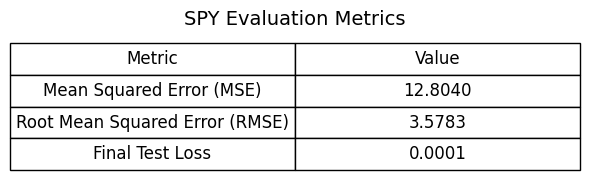

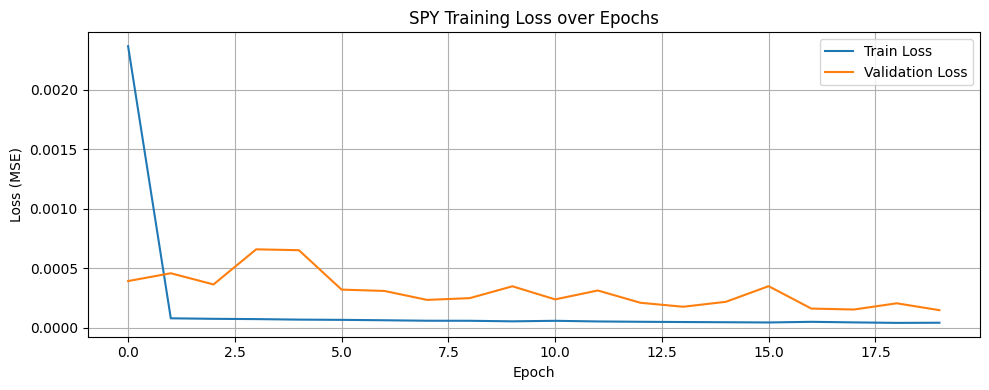

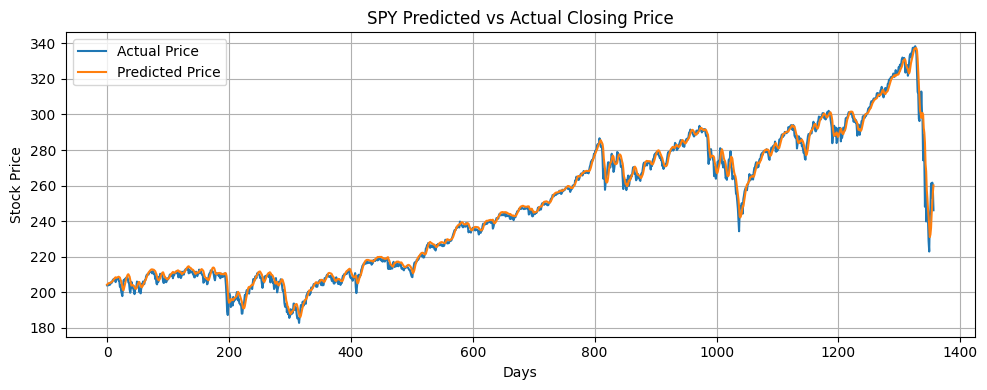

In [15]:
spy_pred, spy_actual = train_and_evaluate("data/stocks/SPY.csv", "SPY")
#qqq_pred, qqq_actual = train_and_evaluate("data/stocks/QQQ.csv", "QQQ")
#schd_pred, schd_actual = train_and_evaluate("data/stocks/SCHD.csv", "SCHD")